In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def calculate_FTTSE(energy, time, is_training=True):
    """
    Calculate the FTTSE (Function of Time To Solution and Energy) metric.
    :param energy: Energy consumption in Joules
    :param time: Time to solution in seconds
    :param is_training: Whether the calculation is for training or inference
    :return: FTTSE value
    """
    if is_training:
        return energy * (time**2)
    else:
        return energy * math.exp(time)
    
def calculate_G_score(alpha, f1, energy):
    """
    Calculate the G-score metric.
    :param alpha: Performance weight (0 <= alpha <= 1)
    :param f1: Performance metric (F1 score)
    :param energy: Energy metric (FTTSE_norm)
    :return: G-score value
    """
    return alpha * f1 + (1-alpha) * (1-energy)

In [3]:
"""
Load the data and calculate the FTTSE values for training and inference
"""

df = pd.read_csv("data/model_performance_results_20241029_050347.csv")
averages_df = df.groupby("Model").mean().reset_index()

averages_df['FTTSE_Training'] = averages_df.apply(
    lambda row: calculate_FTTSE(row['Training_Energy_Joules'], row['Training_Time_Seconds'], is_training=True), axis=1)

averages_df['FTTSE_Inference'] = averages_df.apply(
    lambda row: calculate_FTTSE(row['Inference_Energy_Joules'], row['Inference_Time_Seconds'], is_training=False), axis=1)

print(averages_df)

                    Model  Trial  Training_Time_Seconds  \
0           Decision Tree   10.5               272.1695   
1     Logistic Regression   10.5                22.6170   
2             Naive Bayes   10.5                 8.2715   
3  Support Vector Machine   10.5                 8.6165   

   Training_Energy_Joules  Inference_Time_Seconds  Inference_Energy_Joules  \
0             3319.169474                  0.0400                   0.5940   
1              721.538000                  0.0640                   2.0090   
2               92.382000                  1.2810                  15.8540   
3              108.649000                  1.6195                  51.2665   

   F1_Score  FTTSE_Training  FTTSE_Inference  
0  0.556730    2.458716e+08         0.618242  
1  0.584400    3.690874e+05         2.141780  
2  0.576000    6.320565e+03        57.078176  
3  0.595975    8.066544e+03       258.924760  


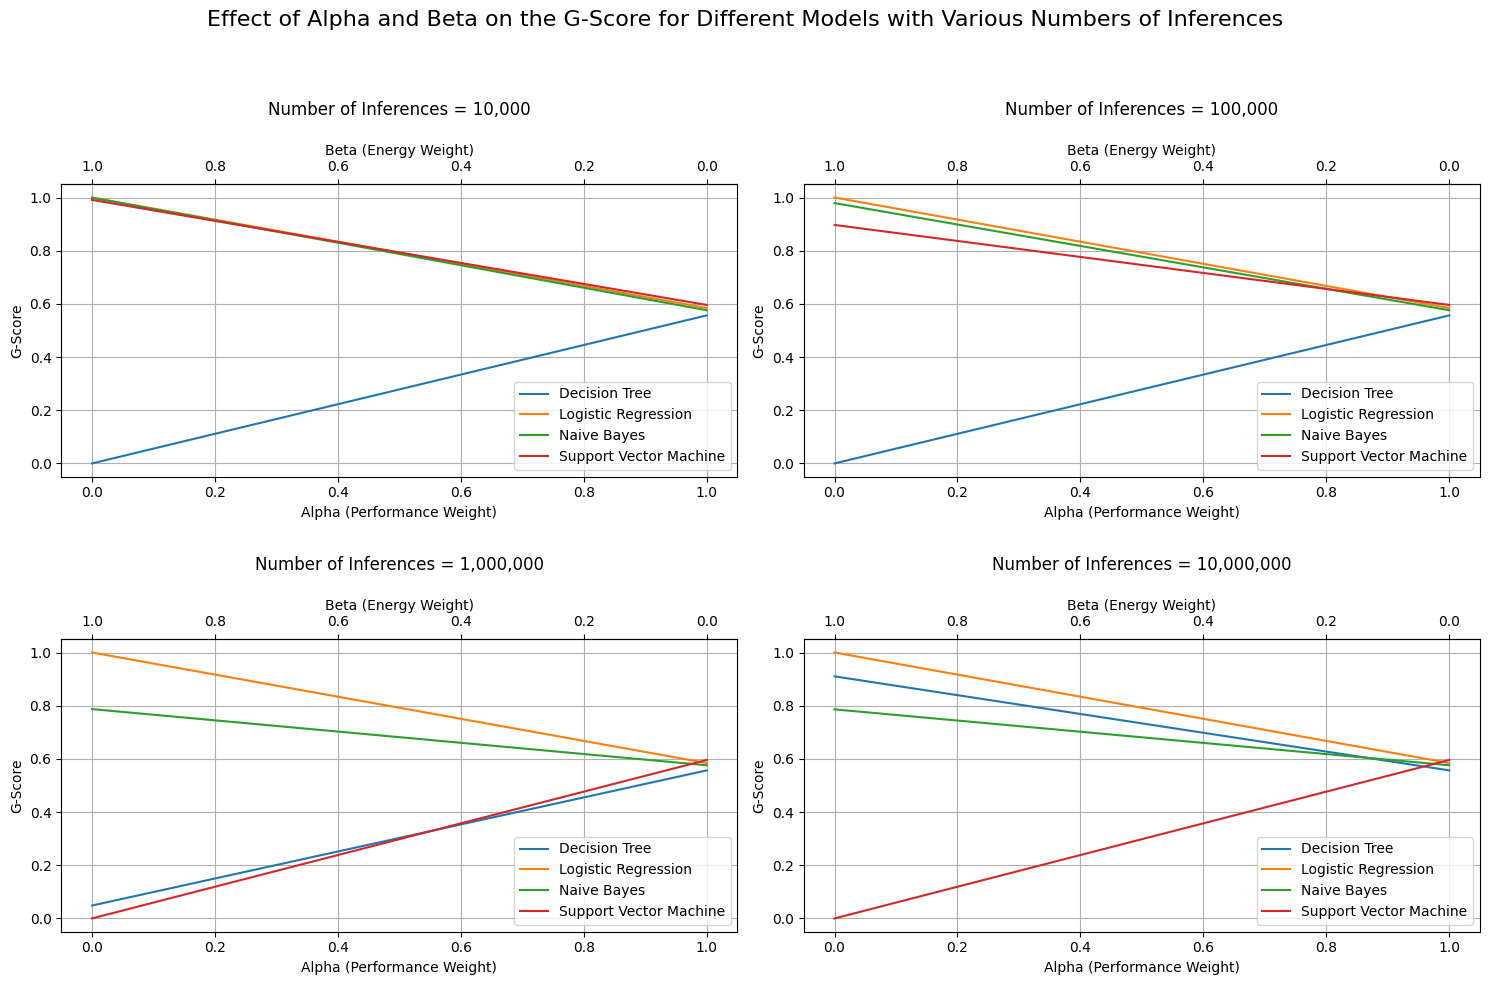

In [5]:
"""
Plot the effect of alpha and beta on the G-score for different models
"""

nr_inferences = [1e4, 1e5, 1e6, 1e7]
alpha_values = np.linspace(0, 1, 1000)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for idx, inf in enumerate(nr_inferences):
    ax = axs[idx]

    # Calculate combined and normalized FTTSE values for current inference number
    averages_df['FTTSE_combined'] = averages_df['FTTSE_Training'] + averages_df['FTTSE_Inference'] * inf
    fttse_min, fttse_max = averages_df['FTTSE_combined'].min(), averages_df['FTTSE_combined'].max()
    averages_df['FTTSE_norm'] = (averages_df['FTTSE_combined'] - fttse_min) / (fttse_max - fttse_min)

    for model in averages_df["Model"]:
        f1 = averages_df[averages_df["Model"] == model]["F1_Score"].values[0]
        energy = averages_df[averages_df["Model"] == model]["FTTSE_norm"].values[0]

        G_scores = []
        for alpha in alpha_values:
            G_scores.append(calculate_G_score(alpha, f1, energy))

        # Plot the effect of alpha on G-score
        ax.plot(alpha_values, G_scores, label=model)

    # Add labels, title, and legend
    ax.set_xlabel("Alpha (Performance Weight)")
    ax.set_ylabel("G-Score")
    ax.set_title(f'\nNumber of Inferences = {inf:,.0f}\n')
    ax.grid(True)
    ax.legend()

    # Add a secondary x-axis at the top for Beta (1 - Alpha)
    secax = ax.secondary_xaxis('top')
    secax.set_xticks(np.linspace(0, 1, 6))  # Adjust tick positions as needed
    secax.set_xticklabels([f"{1 - val:.1f}" for val in np.linspace(0, 1, 6)])
    secax.set_xlabel("Beta (Energy Weight)")

# Set the title for the entire figure
fig.suptitle('Effect of Alpha and Beta on the G-Score for Different Models with Various Numbers of Inferences', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the suptitle
plt.show()